In [9]:
import numpy as np
np.random.seed(1712)

In [58]:
import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import matplotlib.pyplot as plt

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
#from scipy.misc import imread, imresize

In [12]:
use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 1

In [13]:
TRAIN_DIR = "D:/ml/kaggle/State Farm Distracted Driver Detection/all/imgs/train/"
TEST_DIR = "D:/ml/kaggle/State Farm Distracted Driver Detection/all/imgs/test/"

In [14]:
# color_type = 1 - gray
# color_type = 3 - RGB
def get_im_skipy(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = imread(path, True)
    elif color_type == 3:
        img = imread(path)
    # Reduce size
    resized = imresize(img, (img_cols, img_rows))
    return resized

In [15]:
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized


In [16]:
def get_driver_data():
    dr = dict()
    path = os.path.join('D:/ml/kaggle/State Farm Distracted Driver Detection/all', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [17]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []

    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join(TRAIN_DIR, 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers

In [18]:
def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    path = os.path.join(TEST_DIR, '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id

In [19]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


In [20]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


In [21]:
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)


In [22]:
def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model


In [23]:
def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [24]:
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('D:/ml/kaggle/State Farm Distracted Driver Detection/all', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)


In [25]:
def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], color_type, img_rows, img_cols)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


In [26]:
def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], color_type, img_rows, img_cols)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id


In [27]:
def dict_to_list(d):
    ret = []
    for i in d.items():
        ret.append(i[1])
    return ret

In [28]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


In [29]:
def merge_several_folds_geom(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a *= np.array(data[i])
    a = np.power(a, 1/nfolds)
    return a.tolist()

In [30]:
def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    data = np.array(data, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    index = np.array(index, dtype=np.uint32)
    return data, target, index


In [50]:
def create_model_v1(img_rows, img_cols, color_type=1):
    nb_classes = 10
    # number of convolutional filters to use
    nb_filters = 64
    # size of pooling area for max pooling
    nb_pool = 2
    # convolution kernel size
    nb_conv = 4
    model = Sequential()
    model.add(Convolution2D(nb_filters, (nb_conv, nb_conv),
                            border_mode='valid',
                            input_shape=(color_type, img_rows, img_cols), data_format='channels_first'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(nb_filters, (nb_conv, nb_conv), data_format='channels_first'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.summary()
    sgd = SGD(lr=0.1, decay=0, momentum=0.45, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [69]:
def show_train_data(train_data, color_type=1):
    plt.figure(figsize=(12,9))
    row_c = 3
    col_c = 4
    k = 0

    for i in range(1, row_c + 1):
        for j in range(1, col_c + 1):
            plt.subplot(row_c,col_c,k+1)
            if color_type == 3:
                rgb = cv2.cvtColor(train_data[k], cv2.COLOR_BGR2RGB)
                plt.imshow(rgb)
            elif color_type == 1:
                plt.imshow(np.squeeze(train_data[k]), plt.cm.gray)
            k+=1

In [63]:
# loss
def plot_history_loss(fit, axL):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    
# acc
def plot_history_acc(fit, axR):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')

In [70]:
def run_single():
    # input image dimensions
    batch_size = 64
    nb_epoch = 2
    random_state = 51

    yfull_train = dict()
    yfull_test = []
    unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
    X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    unique_list_valid = ['p081']
    X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)
    
    show_train_data(train_data, color_type_global)

    print('Start Single Run')
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))
    print('Train drivers: ', unique_list_train)
    print('Test drivers: ', unique_list_valid)

    model = create_model_v1(img_rows, img_cols, color_type_global)
    fit = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1, validation_data=(X_valid, Y_valid))
    
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    
    plot_history_loss(fit, axL)
    plot_history_acc(fit, axR)
    

    # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
    # print('Score log_loss: ', score[0])

    predictions_valid = model.predict(X_valid, batch_size=64, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)

    # Store valid predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[i]

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=64, verbose=1)
    yfull_test.append(test_prediction)

    print('Final log_loss: {}, rows: {} cols: {} epoch: {}'.format(score, img_rows, img_cols, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, 1)
    print("Creating submission file")
    create_submission(test_res, test_id, info_string)


In [52]:
img_rows, img_cols = 80, 100
train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
Train shape: (22424, 1, 80, 100)
22424 train samples
Read test images
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726
Directory doesnt exists
Test shape: (79726, 1, 80, 100)
79726 test samples


Start Single Run
Split train:  21601 21601
Split valid:  823 823
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075']
Test drivers:  ['p081']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 77, 97)        1088      
_________________________________________________________________
activation_49 (Activation)   (None, 64, 77, 97)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 38, 97)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32, 38, 97)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None

C:\ProgramData\Anaconda3-5.1.0\envs\tensorflow-gpu-new\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), input_shape=(1, 80, 10..., data_format="channels_first", padding="valid")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3-5.1.0\envs\tensorflow-gpu-new\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 21601 samples, validate on 823 samples
Epoch 1/2
21601/21601 [==============================] - 11s 497us/step - loss: 1.8106 - acc: 0.3328 - val_loss: 1.9177 - val_acc: 0.2539
Epoch 2/2
823/823 [==============================] - 0s 373us/step
Score log_loss:  2.656202535600886
79726/79726 [==============================] - 12s 147us/step
Final log_loss: 2.656202535600886, rows: 80 cols: 100 epoch: 2
Creating submission file


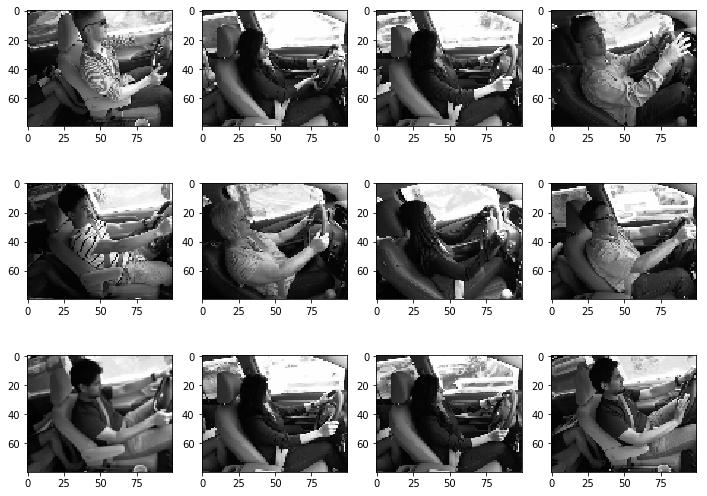

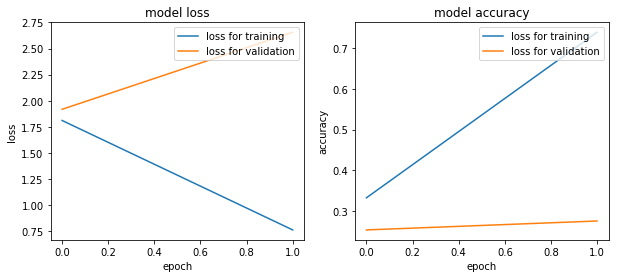

In [71]:
run_single()